In [6]:
from matplotlib.pylab import *
import numpy as np
import pandas as pd
import scipy
from pymc3 import *
from pymc3.distributions.timeseries import *

from scipy.sparse import csc_matrix
from scipy import optimize
import theano.tensor

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


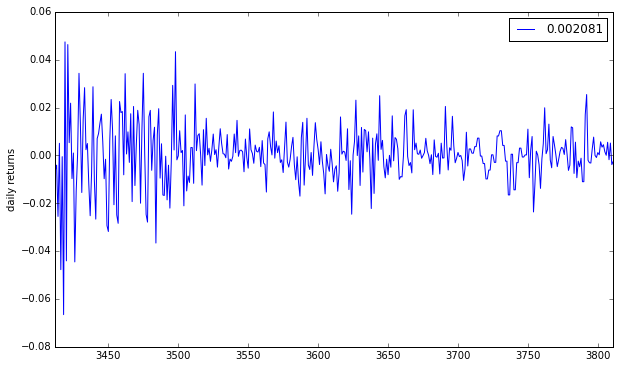

In [2]:
%pylab inline


n = 400

returns = np.genfromtxt("./SP500.csv", skip_header=0)[-n:]
rtn = pd.read_csv("./SP500.csv")[-n:]

rtn.plot(figsize=(10, 6))
plt.ylabel('daily returns')

In [8]:
model = Model()
with model:
    sigma= Exponential('sigma', 1. / .02, testval=.1)

    nu = Exponential('nu', 1. / 10)

    s = GaussianRandomWalk('s', sigma ** -2, shape=len(returns))

    volatility_process = Deterministic('volatility_process', exp(-2*s))

    r = T('r', nu, lam=1/volatility_process, observed=returns)

In [11]:
def run(t=2000):
    if t == "short":
        t = 50
    with model:
        start = find_MAP(vars=[s], fmin=scipy.optimize.fmin_l_bfgs_b)

        step = NUTS(scaling=start)
        trace = sample(100, step, progressbar=True)

        # Start next run at the last sampled position.
        step = NUTS(scaling=trace[-1], gamma=.25)
        trace = sample(t, step, start=trace[-1], progressbar=True)

    traceplot(trace, [nu, sigma])
    fig, ax = plt.subplots(figsize=(15, 8))
    rtn.plot(ax=ax)
    ax.plot(rtn.index, 1/np.exp(trace['s',::30].T), 'r', alpha=.03)
    ax.plot(rtn.index, -1/np.exp(trace['s',::30].T), 'r', alpha=.03)
    ax.set(title='volatility_process', xlabel='time', ylabel='volatility')
    ax.legend(['S&P500', 'stochastic volatility process'])

    show()

 [-----------------100%-----------------] 2000 of 2000 complete in 41.7 sec

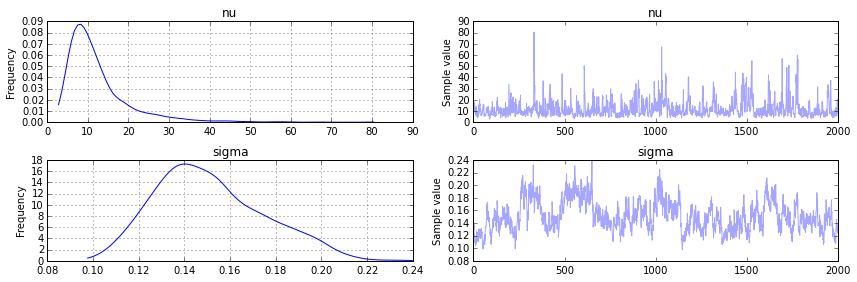

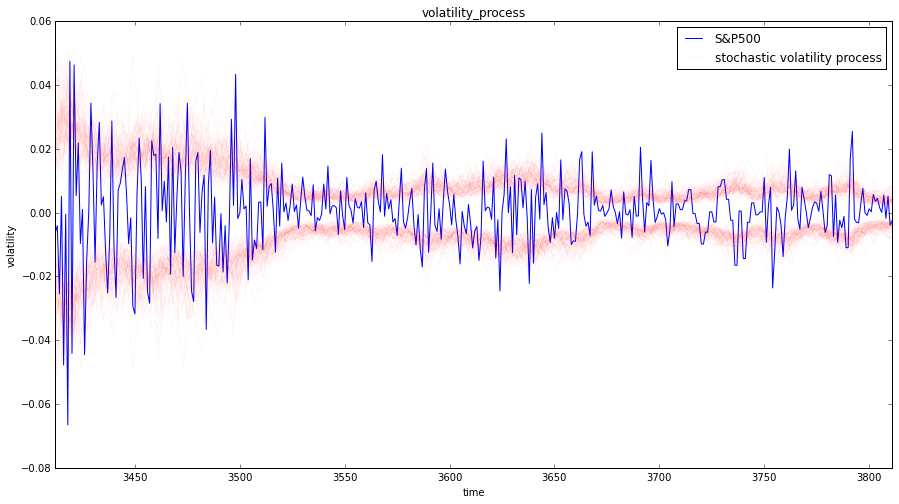

In [12]:
run()